## Classical Hopfield Network Demonstration on MNIST

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

Some Useful Functions

In [2]:
# Useful functions
def IsScalar(x):
    if type(x) in (list, np.ndarray,):
        return False
    else:
        return True

def Thresh(x):
    if IsScalar(x):
        val = 1 if x>0 else -1
    else:
        val = np.ones_like(x)
        val[x<0] = -1.
        '''
        x < 0 This creates a boolean array of the same shape as x, where each element is True if the corresponding element in x is less than 0, and False otherwise.
        val[x < 0]: This selects the elements in val where the condition x < 0 is True
        = -1.: This assigns the value -1. to all selected elements.
        '''
    return val

def Hamming(x, y):
    '''
        d = Hamming(x,y)
        
        Hamming distance between two binary vectors x and y.
        It's the number of digits that differ.
        
        Inputs:
          x and y are arrays of binary vectors, and can be either {0,1} or {-1,1}
        
        Output:
          d is the number of places where the inputs differ
    '''
    d = []
    for xx, yy in zip(x,y):
        dd = 0.
        for xxx,yyy in zip(xx,yy):
            if xxx==1 and yyy!=1:
                dd += 1.
            elif yyy==1 and xxx!=1:
                dd += 1.
        d.append(dd)
    return d

def Perturb(x, p=0.1):
    '''
        y = Perturb(x, p=0.1)
        
        Apply binary noise to x. With probability p, each bit will be randomly
        set to -1 or 1.
        
        Inputs:
          x is an array of binary vectors of {-1,1}
          p is the probability of each bit being randomly flipped
        
        Output:
          y is an array of binary vectors of {-1,1}
    '''
    y = copy.deepcopy(x)
    for yy in y:
        for k in range(len(yy)):
            if np.random.rand()<p:
                yy[k] = Thresh(np.random.randint(2)*2-1)
    return y

Gather n copy of each numbers

In [3]:
# Load the data
df = pd.read_csv('./mnist_test.csv',skiprows=1)

# Function to sample with handling for labels with fewer than 10 samples
def safe_sample(group, n):
    if len(group) < n:
        return group
    return group.sample(n=n, random_state=1)

# Group by the first column (label) and sample 10 entries for each label (if available)
#sampled_df = df.groupby(df.columns[0]).apply(lambda x: safe_sample(x, n=1)).reset_index(drop=True)
sampled_df = df.groupby(df.columns[0], group_keys=False).apply(lambda x: safe_sample(x, n=1)).reset_index(drop=True)
sampled_df = sampled_df.drop(columns=[df.columns[0]])
#print(sampled_df.head)
X = sampled_df.values
print(len(X[4]))


784


/tmp/ipykernel_110023/2737834386.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(df.columns[0], group_keys=False).apply(lambda x: safe_sample(x, n=1)).reset_index(drop=True)


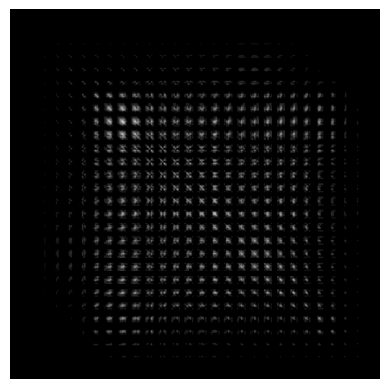

In [4]:
def generate_bipolar_weight(X):
    # Connection weights and biases
    #b = np.zeros((1,N))
    #b = np.sum(X, axis=0) / n
    #W = ( X.T @ X ) / n - np.eye(N) 
    W = ( X.T @ X ) / np.shape(X)[0] - np.eye(np.shape(X)[1]) 
    #W0 = copy.deepcopy(W)
    return W

W=generate_bipolar_weight(X)
#print(W)
plt.subplot(111); plt.imshow(W, cmap='gray'); plt.axis('off');

In [5]:
def Update(W, x):
    xnew = x @ W
    return Thresh(xnew)

def ittrate(x_orig,n_iters=10):
    x = copy.deepcopy(x_orig)
    for k in range(n_iters):
        #print(x)
        x_new = Update(W, x)
        #print(Hamming(x, x_new))
        x = x_new

Corrupting the test data and calling itterate 

In [6]:
# Perturbed memory
def add_corruption():
    k = np.random.randint(len(X)) #selects one of the row to test the network against
    Y = Perturb( X , p=0.1 ) # corrupts the selected row data
    x = Y[k:k+1,]
    err = Hamming(x, X[k:k+1,:]) # checks the error between corrupted and correct data
    #print('Class '+str(k)+' with '+str(err)+' errors')
    x_orig = copy.deepcopy(x)
    #print(x_orig)

    # Notice how the inner product of the perturbed vector is almost
    # othogonal to all the other equilibria. ie. relatively close to zero
    #print('Inner Products: '+str(x@X.T))
    return k,x,x_orig

How close are we to recalling a memory?

In [7]:
def list_errors(x):
    errors=[]
    for idx,t in enumerate(X):
        d = Hamming(x, [t])[0]
        #print('Memory '+str(idx)+' has error '+str(d))
        errors.append([idx,d])
    return errors

Calculate the probability of getting correct result

In [8]:
#k,x=add_corruption()
#ittrate(10)
#list_errors()

def evaluate_probability(n_times):
    correct=0
    total=n_times
    for a in range(n_times):
        k,x,x_orig=add_corruption()
        ittrate(x_orig,100)
        errors=list_errors(x)
        errors.sort(key=lambda x: x[1])
        if errors[0][0]==k:
            correct+=1
        #print(errors)
    return correct/total

probability=evaluate_probability(50)
print("probability: "+str(probability))

probability: 0.14


## Attempt 1
Trying to improve the probability 

probability: 0.14


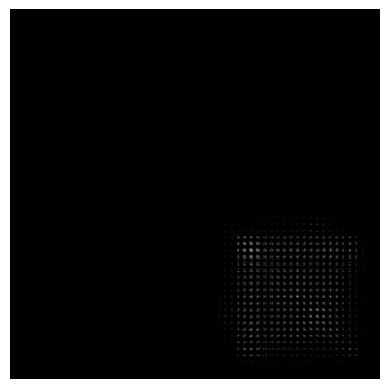

In [9]:
#original_data = np.random.randint(0, 2, (10, 16))

# Transform data to add more attributes (e.g., square the values and concatenate)
X_orig=copy.deepcopy(X)
concat_times=3 #try to change this value , use odd numbers for better results
X = np.concatenate([X_orig, X_orig**concat_times], axis=1)

W=generate_bipolar_weight(X)
#print(W)
plt.subplot(111); plt.imshow(W, cmap='gray'); plt.axis('off');

probability=evaluate_probability(50)
print("probability: "+str(probability))

#print("Original data shape:", X_orig)  # (10, 16)
#print("Expanded data shape:", X)  # (10, 32)



probability: 0.12


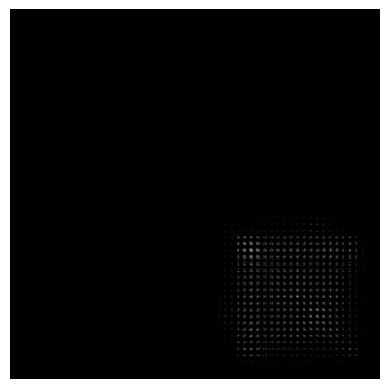

In [10]:
def transform_pattern(pattern):
    return np.repeat(pattern, 2)

transformed_data = np.array([transform_pattern(row) for row in X_orig])
W=generate_bipolar_weight(X)
#print(W)
plt.subplot(111); plt.imshow(W, cmap='gray'); plt.axis('off');

probability=evaluate_probability(50)
print("probability: "+str(probability))